#  Polarizer optimization

## Overview

An interesting feature of Mitsuba is its ability to account for the polarization state of light. This becomes even more powerful when combined with differentiable rendering. 

This tutorial demonstrates how those two concepts can be used together to perform a simple optimization. The setup is the following: we place two linear polarization filters in front of the camera. Initialy those are rotated such that all the light goes through. The optimization process will attempt to rotate one of the filter to minimize the overall brightness of the rendered image. Indeed, it is known that rotating this filter by 90 degrees will lead to complete cancelation of the polarization state, resulting in a darker image.

More information about polarization can be found [here][1].

<div class="admonition important alert alert-block alert-success">

🚀 **What will you learn?**
    
<ul>
  <li>Employ differentiable rendering in the context of polarized rendering</li>  
  <li>Optimize latent variables to control the motion of an object</li>
</ul>
    
</div>

[1]: https://mitsuba3.readthedocs.io/en/latest/src/key_topics/polarization.html

## Reference image

As usual, let's import the necessary libraries. For the sake of this tutorial, we already provide an XML file for the scene containing both linear polarization filter (e.g. using the [<code>polarizer</code>][1] BSDF).

[1]: https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_bsdfs.html#linear-polarizer-material-polarizer

In [1]:
import drjit as dr 
import mitsuba as mi

mi.set_variant('llvm_ad_rgb_polarized')

scene = mi.load_file('../../scenes/polarizers.xml')

We can then perform the rendering of our initial scene. As expected, the two filters are aligned and let linearly polarized light through.

In [2]:
image_init = mi.render(scene, spp=8)

mi.util.convert_to_bitmap(image_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

## Setup optimization

As in the previous tutorial on [pose estimation][1], we setup the optimization using a latent variable to control the rotation of the filter. This rotation angle will be used to construct a transformation matrix that will be applied to all vertices of the filter's mesh. For convinience, we define a function that does all of this, which we will also call later during the optimization loop.

It is important to apply the rotation once before starting the optimization loop as this will *bind* the optimizer variable to the scene parameter. Otherwise during backpropagation the gradients wouldn't be propagate all the way to the optimizer's variable.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/getting_started/tutorials/inverse_rendering/reparam_optimization.html

In [3]:
params = mi.traverse(scene)

# Key of the scene parameter to be optimized
key = 'filter2.vertex_positions'

# Get the initial vertex positions
v_positions_init = dr.unravel(mi.Vector3f, params[key])

# Instantiate an Adam optimizer and define a latent variable `rotation`
opt = mi.ad.Adam(lr=1.0, params=params)
opt['rotation'] = mi.Float(0.0)

# Apply optimized rotation value to mesh vertices
def apply_rotation():
    transform = mi.Transform4f.rotate([0, 0, 1], opt['rotation'])
    positions_new = transform @ v_positions_init
    params[key] = dr.ravel(positions_new)

# Perform the first rotation to enable derivative tracking on the scene parameters
apply_rotation()
opt.update()

## Optimization

Everything is now ready to run the optimization loop. 

In this example the loss function doesn't compare against a reference as the goal is simply to make the image darker. For this we simply use the sum of the pixel values in the rendered image.

In [4]:
angles = []
losses = []

for it in range(100):
    # Perform the differentiable rendering simulation
    image = mi.render(scene, params=params, seed=it, spp=1)

    # Objective: no comparison against a reference, the goal is simply to make the image darker
    ob_val = dr.hmean_async(image)

    # Backpropagate loss to input parameters
    dr.backward(ob_val)

    # Optimizer: take a gradient setp
    opt.step()

    # Optimizer: update the scene parameters
    apply_rotation()
    opt.update()

    print(f"Iteration: {it:2}, rot: {opt['rotation'][0]:.4f}, loss: {ob_val[0]:.4f}", end='\r')
    angles.append(opt['rotation'][0])
    losses.append(ob_val[0])

print() 
print('Optimization complete!')

Iteration: 99, rot: 90.0260, loss: 0.0817
Optimization complete!


## Results

We can now look at the optimized scene, which appears much darker as expected.

In [5]:
image_final = mi.render(scene, seed=0, spp=8)

mi.util.convert_to_bitmap(image_final)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

We plot the filter rotation and image loss accross the optimization loop.

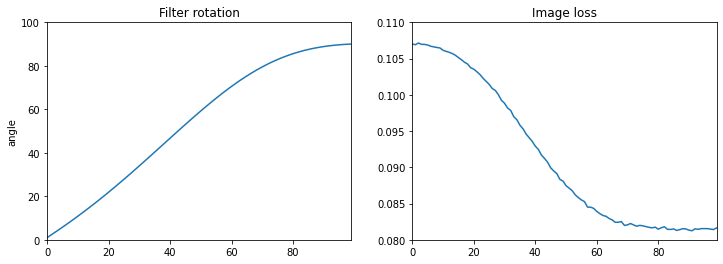

In [15]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=2, figsize=(12,4))

ax[0].plot(angles);
ax[0].set_ylabel('angle'); 
ax[0].set_title('Filter rotation');
ax[0].set_xlim([0, 99]); 
ax[0].set_ylim([0, 100])

ax[1].plot(losses); 
ax[1].set_title('Image loss')
ax[1].set_xlim([0, 99]); 
ax[1].set_ylim([0.08, 0.11])

plt.show()

## See also

- [<code>polarizer</code> plugin](https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_bsdfs.html#linear-polarizer-material-polarizer)